In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt
from keras.optimizers import Adam

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,KFold, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [3]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Corpus Classification")

In [4]:
df = pd.read_excel(os.getcwd()+r"\Data Files\New Categories\Corpus_Flavors.xlsx", encoding = 'unicode_escape')

In [5]:
df.head()

,spend_group,spend_cat_raw_l1,spend_cat_raw_l2,spend_cat_raw_l3,spend_cat_raw_l4,spend_cat_raw_l5,material_group_master_data,material_group_master_data_desc,material,material_desc,...,account_number_desc,cost_center,cost_center_desc,invoice_amount,invoice_amt_rep_curr_mth_rate,label_l1,label_l2,label_l3,label_l4,label_l5
0,Raw,Flavors,Fla/ Sweet,ZZ Fla/Swe/ Alcohol,ZZ Fla/Swe/A&W/ Brandy,Not assigned,R71,Flavors,40614069,Flavor Cherry Brandy Bottle 5kg,...,N001/Not assigned,0010/#,0010/Not assigned,447.85,447.85,Flavors,Fla/ Sweet,NaN,NaN,NaN
1,Raw,Flavors,Fla/ Sweet,ZZ Fla/Swe/ Alcohol,ZZ Fla/Swe/A&W/ Other,Not assigned,R71,Flavors,43692564,Flavor Pinacolada 55577-DO Givaudan BDZ,...,N001/Not assigned,0047/#,0047/Not assigned,52680.73,7701.62,Flavors,Fla/ Sweet,NaN,NaN,NaN
2,Raw,Flavors,Fla/ Sweet,ZZ Fla/Swe/ Alcohol,Not assigned,Not assigned,R71,Flavors,43770855,FlavorWhiskeyBourbonGIV AY8652126KshrNGM,...,N001/Not assigned,0042/#,0042/Not assigned,43650.60,43355.09,Flavors,Fla/ Sweet,NaN,NaN,NaN
3,Raw,Flavors,Fla/ Sweet,ZZ Fla/Swe/ Alcohol,Not assigned,Not assigned,R71,Flavors,43842799,Flavor Wine Powder GIV TL-937-491-1,...,N001/Not assigned,0042/#,0042/Not assigned,121079.53,119888.26,Flavors,Fla/ Sweet,NaN,NaN,NaN
4,Raw,Flavors,Fla/ Sweet,ZZ Fla/Swe/ Alcohol,Not assigned,Not assigned,R71,Flavors,43885774,Flavor Hazelnut Liquid IFF SN378872,...,N001/Not assigned,0051/#,0051/Not assigned,125580.00,17856.29,Flavors,Fla/ Sweet,NaN,NaN,NaN


In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df["label_l2"])
df["label_l2_enc"]=le.transform(df["label_l2"])


# df["label_l2_enc"]=pd.get_dummies(df['label_l2']).values

In [7]:
x_column = ["material_descr_from_po","vendor_desc","account_number_desc","cost_center_desc"]
y_column = ["label_l2_enc"]
seed = 10

In [8]:
df.label_l2.value_counts()

Fla/ Sweet     4470
Fla/ Savory    2845
Name: label_l2, dtype: int64

In [9]:
X_train_1, X_test, y_train_1, y_test = train_test_split(df[x_column], df[y_column], test_size=0.2, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_1, y_train_1, test_size=0.2, random_state=seed)

In [10]:
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)
X_valid.reset_index(inplace = True)


In [54]:
print("Train sample : %.0f "% (X_train.shape[0]))
print("Valid sample : %.0f "% (X_valid.shape[0]))
print("Test sample : %.0f "% (X_test.shape[0]))

Train sample : 4681 
Valid sample : 1171 
Test sample : 1463 


In [12]:
from sklearn.feature_extraction.text import CountVectorizer

for selected_col in x_column:
    sentences_train = X_train[selected_col].values
    sentences_valid = X_valid[selected_col].values
    sentences_test = X_test[selected_col].values

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)

    X_train = X_train.merge(pd.DataFrame(vectorizer.transform(sentences_train).toarray()),left_index=True, right_index = True)
    X_valid = X_valid.merge(pd.DataFrame(vectorizer.transform(sentences_valid).toarray()),left_index=True, right_index = True)
    X_test  = X_test.merge(pd.DataFrame(vectorizer.transform(sentences_test).toarray()),left_index=True, right_index = True)

In [13]:
all_col = list(X_train.columns)

In [14]:
all_col.remove('index')
all_col.remove('material_descr_from_po')
all_col.remove('vendor_desc')
all_col.remove('account_number_desc')
all_col.remove('cost_center_desc')

In [15]:
from keras.utils import to_categorical

# LSTM Model 

In [19]:
from keras.models import Sequential
from keras import layers

input_dim = X_train[all_col].shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

In [20]:
model.compile(loss='categorical_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                70570     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 22        
Total params: 70,592
Trainable params: 70,592
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=100,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=50)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [22]:
loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Valid Accuracy:  0.9172
Testing Accuracy:  0.9091


In [23]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

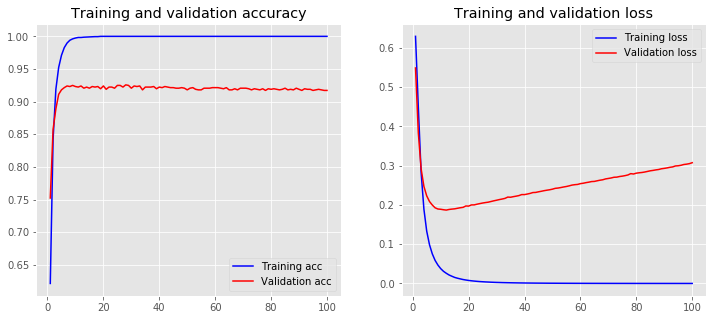

In [24]:
plot_history(history)

# Hyperparameter Tuning

In [30]:
def create_model(learning_rate=0.01, activation='relu'):
  
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr=learning_rate)
  
    # Create your binary classification model  
    model = Sequential()
    model.add(layers.Dense(10, input_dim=input_dim, activation=activation))
    model.add(layers.Dense(2, activation='sigmoid'))
    # Compile the model
    model.compile(optimizer = opt,
                  loss = 'categorical_crossentropy',
                  metrics=["accuracy"])
    return model

In [31]:
params = {'activation': ["relu", "tanh"],
          'batch_size': [16, 32, 64], 
          'epochs': [10,20,30],
          'learning_rate': [0.01, 0.001, 0.0001]}

In [32]:
from keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(build_fn = create_model,
                       verbose = 1)

In [33]:
random_search = RandomizedSearchCV(model,
                                   param_distributions = params, random_state = 10, n_iter = 15,
                                   cv = KFold(3), error_score=0, return_train_score =True)



In [34]:
print("Randomized search..")
search_time_start = time.time()
random_search.fit(X_train[all_col], to_categorical(y_train))
print("Randomized search time:", time.time() - search_time_start)

Randomized search..
Epoch 1/10
3120/3120 [==============================] - 2s 546us/step - loss: 0.6915 - accuracy: 0.5330
Epoch 2/10
3120/3120 [==============================] - 1s 415us/step - loss: 0.6806 - accuracy: 0.6231
Epoch 3/10
3120/3120 [==============================] - 1s 341us/step - loss: 0.6709 - accuracy: 0.6256
Epoch 4/10
3120/3120 [==============================] - 1s 299us/step - loss: 0.6596 - accuracy: 0.6471
Epoch 5/10
3120/3120 [==============================] - 1s 350us/step - loss: 0.6469 - accuracy: 0.6824
Epoch 6/10
3120/3120 [==============================] - 1s 350us/step - loss: 0.6330 - accuracy: 0.7324
Epoch 7/10
3120/3120 [==============================] - 1s 318us/step - loss: 0.6185 - accuracy: 0.7692
Epoch 8/10
3120/3120 [==============================] - 1s 301us/step - loss: 0.6038 - accuracy: 0.7824
Epoch 9/10
3120/3120 [==============================] - 1s 457us/step - loss: 0.5894 - accuracy: 0.7990
Epoch 10/10
3120/3120 [=====================

3120/3120 [==============================] - 1s 399us/step - loss: 0.2717 - accuracy: 0.9388
Epoch 26/30
3120/3120 [==============================] - 1s 407us/step - loss: 0.2595 - accuracy: 0.9413
Epoch 27/30
3120/3120 [==============================] - 1s 384us/step - loss: 0.2479 - accuracy: 0.9474
Epoch 28/30
3120/3120 [==============================] - 1s 402us/step - loss: 0.2371 - accuracy: 0.9500
Epoch 29/30
3120/3120 [==============================] - 1s 391us/step - loss: 0.2268 - accuracy: 0.9538
Epoch 30/30
3120/3120 [==============================] - 1s 301us/step
Epoch 1/30
3121/3121 [==============================] - 2s 632us/step - loss: 0.6910 - accuracy: 0.5418
Epoch 2/30
3121/3121 [==============================] - 1s 402us/step - loss: 0.6762 - accuracy: 0.6081
Epoch 3/30
3121/3121 [==============================] - 1s 394us/step - loss: 0.6547 - accuracy: 0.6117
Epoch 4/30
3121/3121 [==============================] - 1s 383us/step - loss: 0.6320 - accuracy: 0.6504


3120/3120 [==============================] - 1s 229us/step - loss: 0.1947 - accuracy: 0.9622
Epoch 25/30
3120/3120 [==============================] - 1s 228us/step - loss: 0.1847 - accuracy: 0.9651
Epoch 26/30
3120/3120 [==============================] - 1s 228us/step - loss: 0.1753 - accuracy: 0.9660
Epoch 27/30
3120/3120 [==============================] - 1s 234us/step - loss: 0.1663 - accuracy: 0.9692
Epoch 28/30
3120/3120 [==============================] - 1s 219us/step - loss: 0.1578 - accuracy: 0.9715
Epoch 29/30
3120/3120 [==============================] - 1s 239us/step - loss: 0.1498 - accuracy: 0.9740
Epoch 30/30
3120/3120 [==============================] - 0s 112us/step
Epoch 1/30
3121/3121 [==============================] - 1s 316us/step - loss: 0.6812 - accuracy: 0.5771
Epoch 2/30
3121/3121 [==============================] - 1s 235us/step - loss: 0.6548 - accuracy: 0.6014
Epoch 3/30
3121/3121 [==============================] - 1s 239us/step - loss: 0.6315 - accuracy: 0.6088

Epoch 9/20
3120/3120 [==============================] - 1s 197us/step - loss: 6.1126e-04 - accuracy: 1.0000
Epoch 10/20
3120/3120 [==============================] - 1s 193us/step - loss: 5.0304e-04 - accuracy: 1.0000
Epoch 11/20
3120/3120 [==============================] - 1s 199us/step - loss: 4.2391e-04 - accuracy: 1.0000
Epoch 12/20
3120/3120 [==============================] - 1s 214us/step - loss: 3.6090e-04 - accuracy: 1.0000
Epoch 13/20
3120/3120 [==============================] - 1s 215us/step - loss: 3.1197e-04 - accuracy: 1.0000
Epoch 14/20
3120/3120 [==============================] - 1s 210us/step - loss: 2.7044e-04 - accuracy: 1.0000
Epoch 15/20
3120/3120 [==============================] - 1s 195us/step - loss: 2.3862e-04 - accuracy: 1.0000
Epoch 16/20
3120/3120 [==============================] - 1s 270us/step - loss: 2.1133e-04 - accuracy: 1.0000
Epoch 17/20
3120/3120 [==============================] - 1s 198us/step - loss: 1.8818e-04 - accuracy: 1.0000
Epoch 18/20
3120/312

Epoch 7/20
3120/3120 [==============================] - 1s 205us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 8/20
3120/3120 [==============================] - 1s 225us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 9/20
3120/3120 [==============================] - 1s 187us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 10/20
3120/3120 [==============================] - 1s 174us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 11/20
3120/3120 [==============================] - 1s 179us/step - loss: 8.8925e-04 - accuracy: 1.0000
Epoch 12/20
3120/3120 [==============================] - 1s 170us/step - loss: 7.2804e-04 - accuracy: 1.0000
Epoch 13/20
3120/3120 [==============================] - 1s 173us/step - loss: 6.0424e-04 - accuracy: 1.0000
Epoch 14/20
3120/3120 [==============================] - 1s 173us/step - loss: 5.1536e-04 - accuracy: 1.0000
Epoch 15/20
3120/3120 [==============================] - 1s 175us/step - loss: 4.3699e-04 - accuracy: 1.0000
Epoch 16/20
3120/3120 [===============

3120/3120 [==============================] - 1s 363us/step - loss: 0.5846 - accuracy: 0.6859
Epoch 2/30
3120/3120 [==============================] - 1s 265us/step - loss: 0.3550 - accuracy: 0.8901
Epoch 3/30
3120/3120 [==============================] - 1s 319us/step - loss: 0.2175 - accuracy: 0.9436
Epoch 4/30
3120/3120 [==============================] - 1s 274us/step - loss: 0.1414 - accuracy: 0.9689
Epoch 5/30
3120/3120 [==============================] - 1s 296us/step - loss: 0.0940 - accuracy: 0.9830
Epoch 6/30
3120/3120 [==============================] - 1s 277us/step - loss: 0.0647 - accuracy: 0.9920
Epoch 7/30
3120/3120 [==============================] - 1s 272us/step - loss: 0.0461 - accuracy: 0.9952
Epoch 8/30
3120/3120 [==============================] - 1s 274us/step - loss: 0.0335 - accuracy: 0.9984
Epoch 9/30
3120/3120 [==============================] - 1s 290us/step - loss: 0.0250 - accuracy: 0.9987
Epoch 10/30
3120/3120 [==============================] - 1s 267us/step - lo

3121/3121 [==============================] - 0s 121us/step
Epoch 1/30
3121/3121 [==============================] - 1s 385us/step - loss: 0.6096 - accuracy: 0.6847
Epoch 2/30
3121/3121 [==============================] - 1s 267us/step - loss: 0.3541 - accuracy: 0.8888
Epoch 3/30
3121/3121 [==============================] - 1s 273us/step - loss: 0.1893 - accuracy: 0.9542
Epoch 4/30
3121/3121 [==============================] - 1s 266us/step - loss: 0.1141 - accuracy: 0.9779
Epoch 5/30
3121/3121 [==============================] - 1s 264us/step - loss: 0.0738 - accuracy: 0.9897
Epoch 6/30
3121/3121 [==============================] - 1s 268us/step - loss: 0.0500 - accuracy: 0.9952
Epoch 7/30
3121/3121 [==============================] - 1s 277us/step - loss: 0.0355 - accuracy: 0.9978
Epoch 8/30
3121/3121 [==============================] - 1s 273us/step - loss: 0.0269 - accuracy: 0.9978
Epoch 9/30
3121/3121 [==============================] - 1s 271us/step - loss: 0.0198 - accuracy: 0.9984
Epoch

3120/3120 [==============================] - 1s 207us/step - loss: 6.8282e-05 - accuracy: 1.0000
Epoch 28/30
3120/3120 [==============================] - 1s 208us/step - loss: 6.3164e-05 - accuracy: 1.0000
Epoch 29/30
3120/3120 [==============================] - 1s 209us/step - loss: 5.8444e-05 - accuracy: 1.0000
Epoch 30/30
3120/3120 [==============================] - 0s 116us/step
Epoch 1/30
3121/3121 [==============================] - 1s 326us/step - loss: 0.4208 - accuracy: 0.7994
Epoch 2/30
3121/3121 [==============================] - 1s 208us/step - loss: 0.1087 - accuracy: 0.9644
Epoch 3/30
3121/3121 [==============================] - 1s 209us/step - loss: 0.0404 - accuracy: 0.9881
Epoch 4/30
3121/3121 [==============================] - 1s 213us/step - loss: 0.0225 - accuracy: 0.9936
Epoch 5/30
3121/3121 [==============================] - 1s 209us/step - loss: 0.0054 - accuracy: 0.9990
Epoch 6/30
3121/3121 [==============================] - 1s 208us/step - loss: 0.0039 - accurac

In [35]:
print("Best Score: ",
      random_search.best_score_,
      "and Best Params: ",
      random_search.best_params_)

Best Score:  -0.2485447852834311 and Best Params:  {'learning_rate': 0.001, 'epochs': 20, 'batch_size': 16, 'activation': 'tanh'}


Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_193 (Dense)            (None, 10)                70570     
_________________________________________________________________
dense_194 (Dense)            (None, 2)                 22        
Total params: 70,592
Trainable params: 70,592
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 1.0000
Valid Accuracy:  0.9163
Testing Accuracy:  0.9159


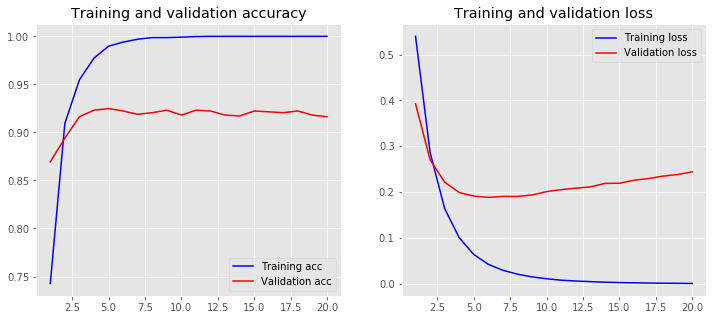

In [39]:
from keras.models import Sequential
from keras import layers

input_dim = X_train[all_col].shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='tanh'))
model.add(layers.Dense(2, activation='sigmoid'))

opt = Adam(learning_rate = 0.001)

model.compile(loss='categorical_crossentropy', 
               optimizer=opt, 
               metrics=['accuracy'])
model.summary()

history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=20,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=16)

loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

# Model Evaluation: Test Data

In [41]:
score, acc = model.evaluate(X_test[all_col], to_categorical(y_test),
                       batch_size=16, verbose=2)

print('Test accuracy:', acc)

Test accuracy: 0.9159261584281921


Confusion matrix, without normalization


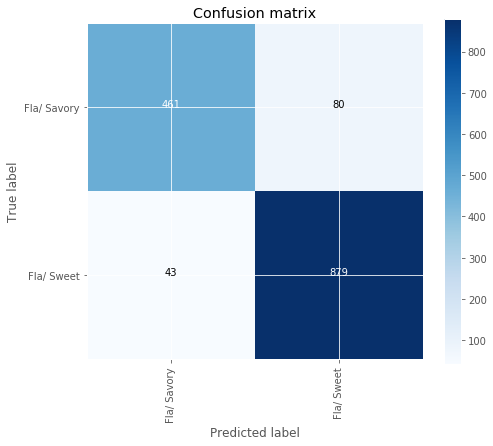

In [42]:
text_labels = le.classes_
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = pd.DataFrame(model.predict_classes(X_test[all_col]));
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(text_labels), normalize=False,
                      title='Confusion matrix')

fig.savefig("txt_classification_NN_BOW" + ".png", pad_inches=5.0)


In [43]:
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test, y_pred)
cohen_score

0.8170333307236247

In [44]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, y_pred)


score_dic= {'Labels':text_labels,
           'precision':precision,
            'recall':recall,
            'fscore':fscore,
            'support':support
           }

pd.DataFrame(score_dic)


,Labels,precision,recall,fscore,support
0,Fla/ Savory,0.914683,0.852126,0.882297,541
1,Fla/ Sweet,0.916580,0.953362,0.934609,922


In [73]:
tmp = pd.DataFrame(data = cnf_matrix,index = text_labels, columns = text_labels)
tmp["total"] = tmp.sum(axis=1)
accuracy= {"Category":[],"Accuracy":[]}
for i in range(tmp.shape[0]):
    accuracy["Category"].append(tmp.index[i])
    accuracy["Accuracy"].append(tmp.iloc[i,i]/tmp.loc[tmp.index[i],"total"])

print("Accuracy:")
print(pd.DataFrame(accuracy))

Accuracy:
      Category  Accuracy
0  Fla/ Savory  0.852126
1   Fla/ Sweet  0.953362


In [67]:
tmp

,Fla/ Savory,Fla/ Sweet,total
Fla/ Savory,461,80,541
Fla/ Sweet,43,879,922


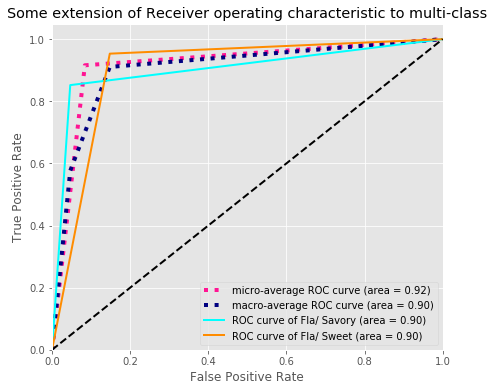

In [47]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

num_labels = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve((y_test==i), (y_pred == i))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
# plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(text_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [48]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_labels):
    precision[i], recall[i], _ = precision_recall_curve((y_test==i), (y_pred == i))
    average_precision[i] = average_precision_score((y_test==i), (y_pred == i))

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
average_precision["micro"] = average_precision_score(to_categorical(y_test), to_categorical(y_pred),
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.88


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.88')

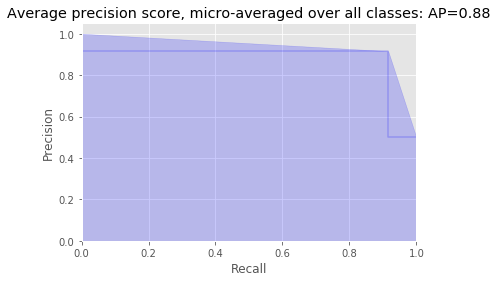

In [49]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

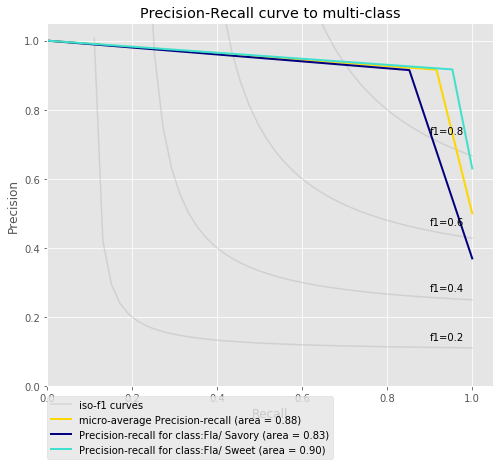

In [51]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(8, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(num_labels), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(text_labels[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))


plt.show()